# Apresentação:

O objetivo desse código é estudar um pouco sobre **valores de SHAP (Shapley - SHapley Additive exPlanations) e LIME (Local Interpretable Model-Agnostic Explanations)**, que constam no edital do BNDES. Para o estudo, será utilizado o artigo do **datacamp**, [IA explicável - Entendendo e confiando nos modelos de aprendizado de máquina](https://www.datacamp.com/pt/tutorial/explainable-ai-understanding-and-trusting-machine-learning-models). Esse tópico é sobre **explicabilidade de IA**, sendo `SHARP` e `LIME`, ferramentas computacionais para gerar um melhor entendimento do modelo.

Esses métodos, chamados de **métodos agnósticos**, podem ser aplicados a **qualquer modelo de aprendizado de máquina**, independentemente de sua estrutura ou tipo. Eles se concentram na análise do par de entrada e saída dos recursos. Esta seção apresentará e discutirá o `LIME` e o `SHAP`, dois modelos substitutos amplamente usados.

## Documentação:
* https://scikit-learn.org/stable/
* https://shap.readthedocs.io/en/latest/
* https://lime-ml.readthedocs.io/en/latest/

In [73]:
# Biblioteca para manipulção de Dados:
import pandas as pd

In [74]:
df = pd.read_csv("E:\Datasets\diabetesKaggle.csv");df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [86]:
# Elementos utilizados em Machine Learning:
target = df.columns[-1]
qtd_classes = len(df[target].unique());qtd_classes
X = df.drop(columns=target)
y = df[target]

# Explicabilidade de IA (XAI):

Facilitar na explicabilidade de modelos de IA é de fato um tema relevânte e a ideia aqui é gerar processos e métodos que gerem clareza e compreensão, a um **nivel humano**, sobre as decisões geradas por IAs e pelos modelos de aprendizado de máquina. Ou seja, o objetivo principal dessa métodologia é implementar **camadas de explicabilidade** a esses modelos, de modo que suas decisões façam mais sentido para o publico que não é da área. (Stakholders e afins).

## Princípios Metodológicos de Explicabilidade de IA:

* **Transparência:** Garantir que as partes interessadas entendam o processo de tomada de decisão dos modelos.

* **Equidade:** Garantir que as decisões dos modelos sejam justas para todos, inclusive para pessoas de grupos protegidos (raça, religião, gênero, deficiência, etnia);

* **Confiança:** Avaliação do nível de confiança dos usuários humanos que usam o sistema de IA;

* **Robustez:** Ser resiliente a mudanças nos dados de entrada ou nos parâmetros do modelo, mantendo um desempenho consistente e confiável mesmo quando confrontado com incertezas ou situações inesperadas;

* **Privacidade:** Garantir a proteção de informações confidenciais do usuário;
  
* **Interpretabilidade:** Fornecer explicações compreensíveis para suas previsões e resultados.


Nesse contexto, a nivel computacional surgem as soluções cobradas no edital, o `shap` e `lime`.

# Construção do Modelo:

Para o estudo da interpretabilidade, para isso, um **classificador Random Forest** foi criado para prever os resultados do *toy dataset* [wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine). Este *dataset* é uma cópia dos conjuntos de dados de reconhecimento de vinhos do UCI ML, [Link para o dataset original](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data). Os dados são os resultados de uma análise química de vinhos cultivados na mesma região da Itália por três diferentes cultivadores. Há treze diferentes medidas realizadas para diferentes constituintes encontrados nos três tipos de vinho.

1. importar bibliotecas relevantes;
2. criar conjuntos de dados de treinamento e teste;
3. criar o modelo; e
4. informar as métricas de desempenho por meio do relatório de classificação.

## Documentação do Modelo:
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [75]:
# Bibliotecas Utilizadas:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [87]:
# Gerando dados de treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, # 30% para dados de teste
                                                    shuffle = True, # Gerando amostras aleatórias
                                                    stratify=y,
                                                    random_state=13)

In [88]:
# Instanciando o Modelo:
rf_clf = RandomForestClassifier(max_features = qtd_classes, # 2
                                criterion = 'gini',  # A função para medir a qualidade de uma divisão.
                                n_estimators = 100, # O número de árvores na floresta.
                                bootstrap = True) # Usa reamostragem na construção da floresta.

# Treinando Modelo:
rf_clf.fit(X_train, y_train);rf_clf

RandomForestClassifier(max_features=2)

In [89]:
# Gerando predições - Testando Modelo:
y_pred = rf_clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       162
           1       0.62      0.72      0.67        69

    accuracy                           0.78       231
   macro avg       0.75      0.77      0.75       231
weighted avg       0.80      0.78      0.79       231



# SHAP

Significa **SHapley AdditiveexPlanations**. Esse método tem como objetivo explicar a previsão de uma instância/observação calculando a contribuição de cada recurso para a previsão. Utilização:

* A biblioteca principal do `shap` é importada.
* A classe `TreeExplainer` é usada para explicar modelos baseados em árvores, juntamente com o initjs.
* A função `shape.initjs()` inicializa o código JavaScript necessário para exibir as visualizações do SHAP em um ambiente de notebook jupyter.
* Por fim, após instanciar a classe TreeExplainer com o classificador de floresta aleatória, os valores de forma são computados para cada recurso de cada instância no conjunto de dados de teste.

In [99]:
# Importando Bibliotecas:
import shap
import matplotlib.pyplot as plt

In [101]:
# Criando as Explicações:
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test)

O **SHAP** oferece uma série de ferramentas de visualização para melhorar a interpretabilidade do modelo, discutiremos aqui: 
1. Importância da variável com o gráfico de resumo;
2. Gráfico de resumo de um alvo específico; e
3. Gráfico de dependência.

## Importância da variável com gráfico de resumo

Nesse gráfico, os recursos são classificados por seus valores médios de **SHAP**, mostrando os recursos mais importantes na parte superior e os menos importantes na parte inferior, usando a função `summary_plot()`. Isso ajuda a entender o impacto de cada recurso nas previsões do modelo.

Variable Importance Plot - Global Interpretation


<Figure size 640x480 with 0 Axes>

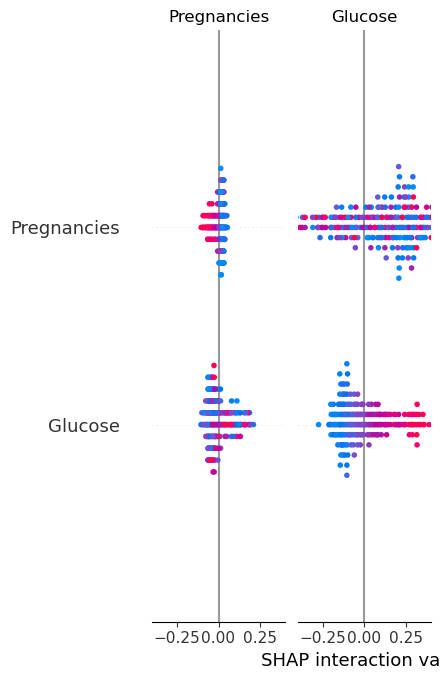

In [102]:
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test,plot_type="bar")

Abaixo está a interpretação que pode ser feita a partir do gráfico acima:

* Podemos observar que as cores vermelha e azul ocupam metade dos retângulos horizontais de cada classe. Isso significa que cada recurso tem um impacto igual na classificação dos casos de diabetes (rótulo=1) e não diabetes (rótulo=0).
* No entanto, a glicose, a idade e o IMC são os três primeiros recursos com maior poder de previsão.
Por outro lado, Pregnancies, SkinThicknes, Insulin e BloodPressure não contribuem tanto quanto os três primeiros recursos.

## Gráfico de dependência:

Diferentemente dos gráficos de resumo, os gráficos de dependência mostram a relação entre um recurso específico e o resultado previsto para cada instância dos dados. Essa análise é realizada por vários motivos e não se limita à obtenção de informações mais detalhadas e à validação da importância do recurso que está sendo analisado, confirmando ou contestando os resultados dos gráficos de resumo ou outras medidas globais de importância do recurso. 

# LIME

**Local Interpretable Model-agnostic Explanations** (LIME). Em vez de fornecer uma compreensão global do modelo em todo o conjunto de dados, o LIME se concentra em explicar a previsão do modelo para instâncias individuais.

O LIME explainer pode ser configurado em duas etapas principais: 
1. importar o módulo lime;
2. Ajustar o explicador usando os dados de treinamento e os alvos. Durante essa fase, o modo é definido como classificação, o que corresponde à tarefa que está sendo executada.

In [103]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

In [104]:
# Get the class names
class_names = ['Has diabetes', 'No diabetes']

# Get the feature names
feature_names = list(X_train.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, feature_names =     
                                 feature_names,
                                 class_names = class_names, 
                                 mode = 'classification')

In [109]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [110]:
dt_clf = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 2)
dt_clf.fit(X_train, y_train)

# Predict on the test data and evaluate the model
y_pred = dt_clf.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80       181
           1       0.41      0.66      0.50        50

    accuracy                           0.72       231
   macro avg       0.65      0.70      0.65       231
weighted avg       0.78      0.72      0.74       231



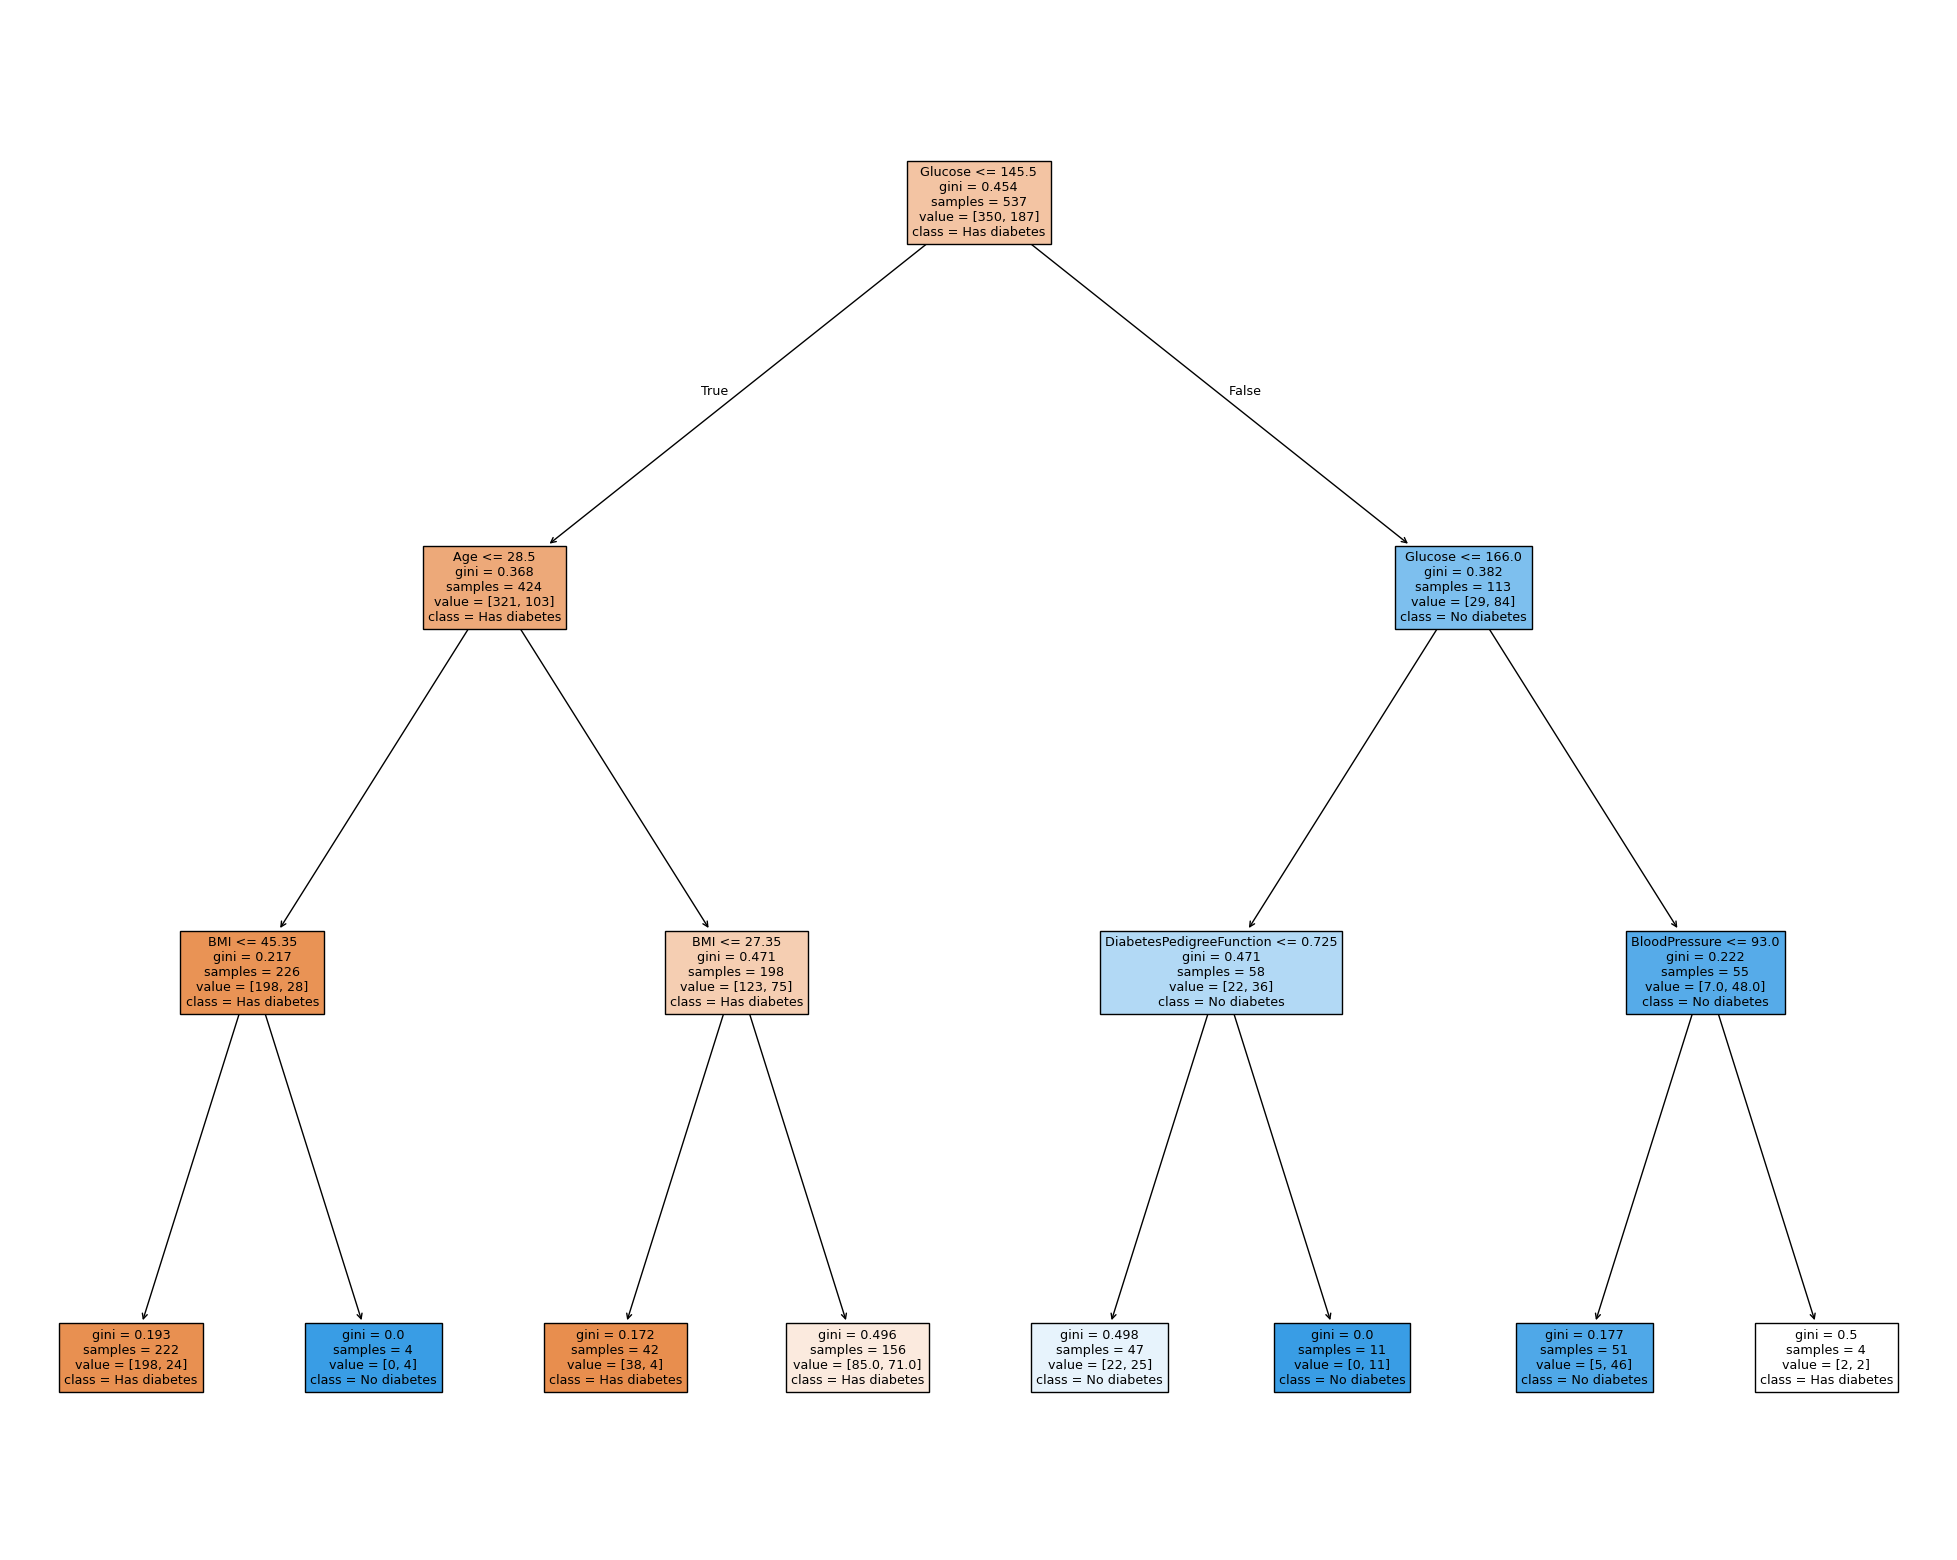

In [112]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt_clf,
               	feature_names = feature_names,
               	class_names = class_names,
               	filled=True)